In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime as dt, timedelta as tmd
import tqdm

from importlib import reload
import xAPIConnector.xAPIConnector
reload(xAPIConnector.xAPIConnector)
from xAPIConnector.xAPIConnector import *


import xAPIConnector.DataLoader
reload(xAPIConnector.DataLoader)
from xAPIConnector.DataLoader import *

# import xAPIConnector.config
# reload(xAPIConnector.config)
# from xAPIConnector.config import user_id, pwd

user_id = "17340399"
pwd = "MASPROJEKT2025"

In [2]:
def mean_std(x):
    return x.mean() / x.std()

def win_rate(x):
    return (x>0).sum() / (x!=0).sum()

agg_functions = ['count', 'mean', 'std', mean_std, win_rate]

In [7]:
symbols = ['BITCOIN', 'ETHEREUM']
start, interval = '2024-01-01 00:00:00', '1h'

dl = DataLoader(user_id, pwd)
data = dl.getData(symbols=symbols, start_date=start, interval=interval)

[2025-01-13 16:07:40.810373] Loguję do API...
	Wysyłam zapytanie do API...
	Wysyłam zapytanie do API...
[2025-01-13 16:07:44.620371] Wylogowuję z API...


In [8]:
data.columns = ['btc', 'eth']

In [9]:
data.head()

,btc,eth
Date,,
2024-01-01 01:00:00,42419.0,2290.95
2024-01-01 02:00:00,42551.0,2298.65
2024-01-01 03:00:00,42526.0,2288.75
2024-01-01 04:00:00,42282.0,2269.75
2024-01-01 05:00:00,42344.0,2275.65


In [10]:
from scipy.stats import pearsonr

def calculate_c_value(data, column, time_window):
    data = data.sort_index()

    c_values = []

    time_numeric = np.arange(time_window*2+1)
    for i in range(len(data)):
        if (i < time_window) or (i >= len(data)-time_window):
            c_values.append(np.NaN)
        else:
            start = i - time_window
            end = i + time_window + 1
            window = data.iloc[start:end]
            prices = window[column]

            c_value, _ = pearsonr(time_numeric, prices)
            c_values.append(c_value)

    return pd.Series(c_values, index=data.index)


In [11]:
data['btc_change'] = data['btc'].pct_change(fill_method=None)
data['btc_diff'] = data['btc'].diff()
data['btc_cval'] = calculate_c_value(data, column="btc", time_window=5)
data['btc_bcval'] = calculate_c_value(data, column="btc", time_window=2).shift(2)
data['target'] = data['btc'].pct_change(-5).shift(-1)

In [12]:
data['target'].head(10)

Date
2024-01-01 01:00:00    0.004794
2024-01-01 02:00:00    0.001838
2024-01-01 03:00:00   -0.005200
2024-01-01 04:00:00   -0.006033
2024-01-01 05:00:00   -0.010601
2024-01-01 06:00:00   -0.006825
2024-01-01 07:00:00   -0.003568
2024-01-01 08:00:00   -0.004054
2024-01-01 09:00:00    0.000634
2024-01-01 10:00:00   -0.002387
Name: target, dtype: float64

In [16]:
data.groupby(pd.qcut(data['btc_bcval'], 5))[['btc_change', 'btc_cval', 'target']].agg(agg_functions)

C:\Users\unoci\AppData\Local\Temp\ipykernel_11820\401519128.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(pd.qcut(data['btc_bcval'], 5))[['btc_change', 'btc_cval', 'target']].agg(agg_functions)


btc_change                                         btc_cval  \
                      count      mean       std  mean_std  win_rate    count   
btc_bcval                                                                      
(-1.001, -0.755]       1752 -0.002568  0.005619 -0.456966  0.306286     1749   
(-0.755, -0.266]       1752 -0.000834  0.005962 -0.139939  0.470890     1751   
(-0.266, 0.402]        1751  0.000031  0.005218  0.006036  0.506003     1750   
(0.402, 0.804]         1752  0.001351  0.005520  0.244717  0.558352     1752   
(0.804, 0.999]         1752  0.002545  0.004754  0.535262  0.724098     1751   

                                                         target            \
                      mean       std  mean_std  win_rate  count      mean   
btc_bcval                                                                   
(-1.001, -0.755] -0.496130  0.466940 -1.062514  0.177511   1748 -0.000223   
(-0.755, -0.266] -0.221450  0.563779 -0.392796  0.350457   1752 -0.000818   
(-0.266, 0.402]   0.065697  0.586701  0.111977  0.544260   1750 -0.000035   
(0.402, 0.804]    0.362174  0.531366  0.681591  0.752283   1752 -0.000547   
(0.804, 0.999]    0.534697  0.464532  1.151043  0.847603   1751 -0.000169   

                                                
                       std  mean_std  win_rate  
btc_bcval                                       
(-1.001, -0.755]  0.012077 -0.018437  0.464877  
(-0.755, -0.266]  0.012284 -0.066572  0.446918  
(-0.266, 0.402]   0.012536 -0.002826  0.485143  
(0.402, 0.804]    0.011894 -0.045953  0.484295  
(0.804, 0.999]    0.013733 -0.012310  0.504566

In [17]:
data.groupby(data['btc_bcval']>0)[['btc_change', 'btc_cval', 'target']].agg(agg_functions)

btc_change                                         btc_cval  \
               count      mean       std  mean_std  win_rate    count   
btc_bcval                                                               
False           4199 -0.001422  0.005734 -0.248001  0.408051     4192   
True            4563  0.001509  0.005309  0.284322  0.609622     4561   

                                                  target                      \
               mean       std  mean_std  win_rate  count      mean       std   
btc_bcval                                                                      
False     -0.299232  0.561850 -0.532584  0.304762   4196 -0.000606  0.012285   
True       0.369359  0.543136  0.680049  0.745343   4561 -0.000132  0.012729   

                               
           mean_std  win_rate  
btc_bcval                      
False     -0.049294  0.455217  
True      -0.010355  0.497370

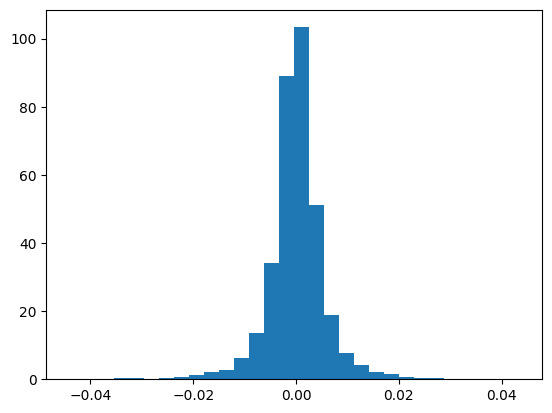

In [18]:
plt.hist(data['btc_change'], bins=30, density=True);

### LSTM

In [19]:
import torch
import torch.nn as nn

In [20]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, col, n_steps):
    df = dc(df)[[col]]

    for i in range(1, n_steps+1):
        df[f'{col}(t-{i})'] = df[col].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 12
shifted_df = prepare_dataframe_for_lstm(data.dropna(), 'btc_diff', lookback)
shifted_df

,btc_diff,btc_diff(t-1),btc_diff(t-2),btc_diff(t-3),btc_diff(t-4),btc_diff(t-5),btc_diff(t-6),btc_diff(t-7),btc_diff(t-8),btc_diff(t-9),btc_diff(t-10),btc_diff(t-11),btc_diff(t-12)
Date,,,,,,,,,,,,,
2024-01-01 18:00:00,90.0,-52.0,166.0,-102.0,76.0,-39.0,1.0,37.0,98.0,55.0,100.0,162.0,-158.0
2024-01-01 19:00:00,292.0,90.0,-52.0,166.0,-102.0,76.0,-39.0,1.0,37.0,98.0,55.0,100.0,162.0
2024-01-01 20:00:00,425.0,292.0,90.0,-52.0,166.0,-102.0,76.0,-39.0,1.0,37.0,98.0,55.0,100.0
2024-01-01 21:00:00,164.0,425.0,292.0,90.0,-52.0,166.0,-102.0,76.0,-39.0,1.0,37.0,98.0,55.0
2024-01-01 22:00:00,-68.0,164.0,425.0,292.0,90.0,-52.0,166.0,-102.0,76.0,-39.0,1.0,37.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-13 06:00:00,-322.2,222.2,51.6,1.4,-1119.8,788.3,596.1,-396.8,-339.8,39.2,-340.2,-144.8,85.0
2025-01-13 07:00:00,-544.1,-322.2,222.2,51.6,1.4,-1119.8,788.3,596.1,-396.8,-339.8,39.2,-340.2,-144.8
2025-01-13 08:00:00,-46.7,-544.1,-322.2,222.2,51.6,1.4,-1119.8,788.3,596.1,-396.8,-339.8,39.2,-340.2


In [21]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[  90. ,  -52. ,  166. , ...,  100. ,  162. , -158. ],
       [ 292. ,   90. ,  -52. , ...,   55. ,  100. ,  162. ],
       [ 425. ,  292. ,   90. , ...,   98. ,   55. ,  100. ],
       ...,
       [ -46.7, -544.1, -322.2, ..., -339.8,   39.2, -340.2],
       [-557.5,  -46.7, -544.1, ..., -396.8, -339.8,   39.2],
       [-191.7, -557.5,  -46.7, ...,  596.1, -396.8, -339.8]])

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[ 0.00664962, -0.04177323,  0.03256607, ...,  0.01005968,
         0.03120205, -0.07791986],
       [ 0.07553282,  0.00664962, -0.04177323, ..., -0.00528559,
         0.01005968,  0.03120205],
       [ 0.12088662,  0.07553282,  0.00664962, ...,  0.00937766,
        -0.00528559,  0.01005968],
       ...,
       [-0.0399659 , -0.20958227, -0.13391304, ..., -0.13991475,
        -0.01067349, -0.14005115],
       [-0.21415175, -0.0399659 , -0.20958227, ..., -0.15935209,
        -0.13991475, -0.01067349],
       [-0.08941176, -0.21415175, -0.0399659 , ...,  0.17923274,
        -0.15935209, -0.13991475]])

In [23]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((8740, 12), (8740,))

In [24]:
X = dc(np.flip(X, axis=1))
X

array([[-0.07791986,  0.03120205,  0.01005968, ..., -0.05882353,
         0.03256607, -0.04177323],
       [ 0.03120205,  0.01005968, -0.00528559, ...,  0.03256607,
        -0.04177323,  0.00664962],
       [ 0.01005968, -0.00528559,  0.00937766, ..., -0.04177323,
         0.00664962,  0.07553282],
       ...,
       [-0.14005115, -0.01067349, -0.13991475, ...,  0.05173061,
        -0.13391304, -0.20958227],
       [-0.01067349, -0.13991475, -0.15935209, ..., -0.13391304,
        -0.20958227, -0.0399659 ],
       [-0.13991475, -0.15935209,  0.17923274, ..., -0.20958227,
        -0.0399659 , -0.21415175]])

In [25]:
split_index = int(len(X) * 0.95)

split_index

8303

In [26]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8303, 12), (437, 12), (8303,), (437,))

In [27]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape
     

((8303, 12, 1), (437, 12, 1), (8303, 1), (437, 1))

In [28]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape
     

(torch.Size([8303, 12, 1]),
 torch.Size([437, 12, 1]),
 torch.Size([8303, 1]),
 torch.Size([437, 1]))

In [29]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [30]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
device = 'cpu'

In [32]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break
     

torch.Size([16, 12, 1]) torch.Size([16, 1])


In [33]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [34]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [35]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [45]:
learning_rate = 0.0001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.018
Batch 200, Loss: 0.019
Batch 300, Loss: 0.017
Batch 400, Loss: 0.016
Batch 500, Loss: 0.017

Val Loss: 0.023
***************************************************

Epoch: 2
Batch 100, Loss: 0.017
Batch 200, Loss: 0.016
Batch 300, Loss: 0.017
Batch 400, Loss: 0.017
Batch 500, Loss: 0.020

Val Loss: 0.023
***************************************************

Epoch: 3
Batch 100, Loss: 0.015
Batch 200, Loss: 0.017
Batch 300, Loss: 0.017
Batch 400, Loss: 0.020
Batch 500, Loss: 0.017

Val Loss: 0.023
***************************************************

Epoch: 4
Batch 100, Loss: 0.019
Batch 200, Loss: 0.021
Batch 300, Loss: 0.015
Batch 400, Loss: 0.018
Batch 500, Loss: 0.014

Val Loss: 0.023
***************************************************

Epoch: 5
Batch 100, Loss: 0.018
Batch 200, Loss: 0.016
Batch 300, Loss: 0.017
Batch 400, Loss: 0.017
Batch 500, Loss: 0.018

Val Loss: 0.023
***************************************************

Epoch: 6
Batch 100, Loss: 0.01

KeyboardInterrupt: 

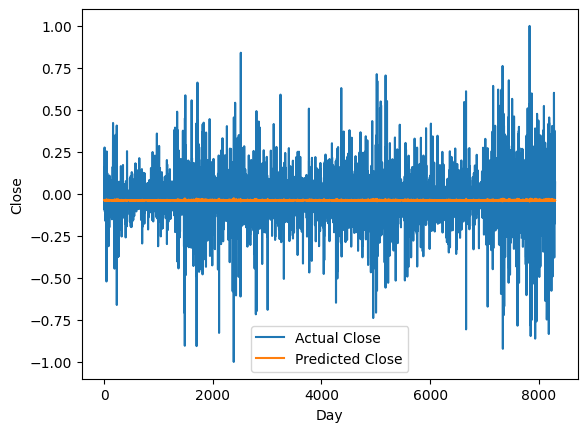

In [37]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [38]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([-39.60697005, -40.93402414, -42.98186013, ..., -41.54652325,
       -39.80286664, -41.10785342])

In [39]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 89.99999943, 292.0000058 , 425.00000262, ..., -23.90000083,
       107.29999945, 273.00000313])

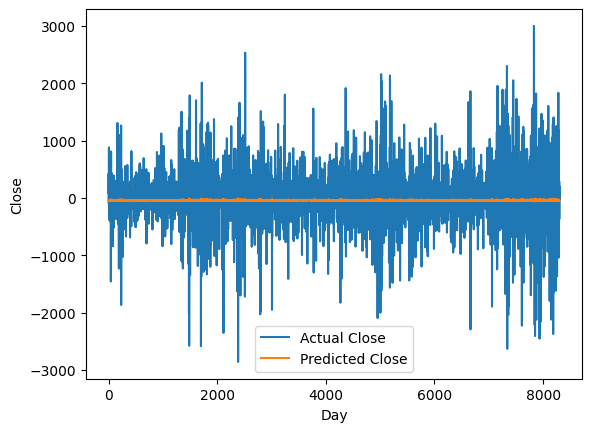

In [40]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [41]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([-42.81669392, -34.26431994, -42.27402367, -42.86830085,
       -42.73965495, -38.34913305, -38.8568998 , -41.29217013,
       -42.004573  , -42.75486174, -41.69690873, -33.54857419,
       -42.35992233, -45.93526448, -36.34583589, -40.12767131,
       -36.69211796, -42.06881948, -32.72819442, -39.90125191,
       -37.08081953, -35.85087255, -18.4422074 , -32.0198008 ,
       -39.03107866, -41.47280531, -39.936505  , -40.28922154,
       -37.55153067, -45.69226182, -44.59140864, -33.21174174,
       -38.6221997 , -43.32784724, -34.0502779 , -41.85931107,
       -40.11034519, -39.71409485, -40.06941141, -41.24467077,
       -41.68685827, -43.65833261, -39.16613718, -39.55941608,
       -43.43003421, -23.64695864, -43.93791021, -49.32294705,
       -38.66339566, -43.70086135, -37.53523145, -37.05394547,
       -31.6177496 , -26.27673815, -33.61728876, -40.21575486,
       -42.40175191, -42.05791691, -38.36048351, -40.24520708,
       -39.34800682, -40.91255767, -38.46008139, -38.95

In [42]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([-5.65700018e+02,  2.80500006e+02,  2.85700006e+02,  2.46499997e+02,
       -1.92599999e+02, -1.06099999e+02,  1.40699999e+02,  1.91300005e+02,
        2.55500010e+02,  1.37600000e+02, -6.26300013e+02,  3.00400006e+02,
        6.22700015e+02, -3.95700014e+02,  3.17999992e+01, -3.10899995e+02,
        2.40500003e+02, -6.85500023e+02,  6.34000002e+01, -2.59599997e+02,
       -3.62699982e+02, -1.87069999e+03, -4.60999999e+02,  6.00999997e+01,
        1.93599998e+02, -1.03000015e+01,  2.53000003e+01, -2.39599995e+02,
        6.20599993e+02,  4.36999991e+02, -6.82400024e+02, -7.74000014e+01,
        3.69899991e+02, -5.79099991e+02,  2.40900001e+02,  9.89999891e+00,
       -3.31999980e+01,  6.90000194e+00,  1.21799998e+02,  1.55200001e+02,
        3.52499999e+02, -1.18099997e+02, -4.81000026e+01,  3.52199993e+02,
       -1.50109998e+03,  6.12899986e+02,  1.06050001e+03, -1.87600004e+02,
        3.65999997e+02, -2.68200001e+02, -2.69500006e+02, -7.41300006e+02,
       -1.13830002e+03, -

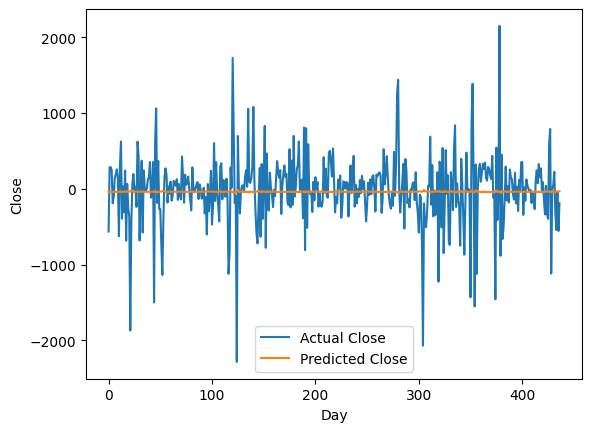

In [43]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

## Easy ones

In [54]:
data['ratio'] = data['btc'] / data['eth']
data['ratio_change'] = data['ratio'].pct_change()
data['target'] = data['ratio_change'].shift(-1)
data['ratio_cval'] = calculate_c_value(data, column="ratio", time_window=5)
data['ratio_bcval'] = calculate_c_value(data, column="ratio", time_window=2).shift(2)

In [55]:
data.groupby(pd.qcut(data['ratio_bcval'], 5))[['ratio_change', 'ratio_cval', 'target']].agg(agg_functions)

C:\Users\unoci\AppData\Local\Temp\ipykernel_11820\2305919562.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(pd.qcut(data['ratio_bcval'], 5))[['ratio_change', 'ratio_cval', 'target']].agg(agg_functions)


ratio_change                                          \
                        count      mean       std  mean_std  win_rate   
ratio_bcval                                                             
(-1.0, -0.732]           1752 -0.001753  0.003989 -0.439481  0.316781   
(-0.732, -0.205]         1752 -0.000644  0.004801 -0.134181  0.472603   
(-0.205, 0.469]          1751 -0.000007  0.003537 -0.001870  0.505997   
(0.469, 0.831]           1752  0.000987  0.003746  0.263454  0.579338   
(0.831, 1.0]             1752  0.001733  0.002961  0.585240  0.757420   

                 ratio_cval                                         target  \
                      count      mean       std  mean_std  win_rate  count   
ratio_bcval                                                                  
(-1.0, -0.732]         1752 -0.483134  0.488619 -0.988776  0.182648   1752   
(-0.732, -0.205]       1752 -0.154045  0.575938 -0.267468  0.406393   1752   
(-0.205, 0.469]        1751  0.139969  0.572478  0.244497  0.594517   1751   
(0.469, 0.831]         1752  0.406626  0.521709  0.779410  0.763128   1752   
(0.831, 1.0]           1746  0.594198  0.429514  1.383421  0.879566   1751   

                                                          
                      mean       std  mean_std  win_rate  
ratio_bcval                                               
(-1.0, -0.732]    0.000043  0.004232  0.010132  0.545662  
(-0.732, -0.205]  0.000122  0.004080  0.029831  0.540525  
(-0.205, 0.469]   0.000073  0.003773  0.019473  0.529412  
(0.469, 0.831]    0.000022  0.004397  0.005112  0.509703  
(0.831, 1.0]      0.000056  0.003686  0.015157  0.506849

In [80]:
import pandas as pd
import numpy as np

def mean_revert_with_pnl(data, col, roll=10, tp=1, sl=3, entry=2):
    data = data.reset_index(drop=True)
    
    data['rolling_mean'] = data[col].rolling(window=roll).mean()
    data['rolling_std'] = data[col].rolling(window=roll).std()

    data['position'] = 0 
    data['entry_price'] = np.nan  
    data['exit_reason'] = '' 
    data['pnl'] = 0.0  
    data['trade_pnl'] = 0.0  

    cumulative_pnl = 0.0 

    for i in range(roll, len(data)):
        mean = data.loc[i, 'rolling_mean']
        std = data.loc[i, 'rolling_std']
        price = data.loc[i, col]

        if pd.isna(mean) or pd.isna(std):
            continue

        if data.loc[i - 1, 'position'] == 0:  
            
            if price > mean + std * entry:
                data.loc[i, 'position'] = -1
                data.loc[i, 'entry_price'] = price
            elif price < mean - std * entry:
                data.loc[i, 'position'] = 1
                data.loc[i, 'entry_price'] = price
        else:
            entry_price = data.loc[i - 1, 'entry_price']
            position = data.loc[i - 1, 'position']

            trade_pnl = (price - entry_price) * position
            data.loc[i, 'trade_pnl'] = trade_pnl

            if position == 1 and price > mean + std * sl:
                data.loc[i, 'position'] = 0  
                data.loc[i, 'exit_reason'] = 'sl'
                cumulative_pnl += trade_pnl
            elif position == -1 and price < mean - std * sl:
                data.loc[i, 'position'] = 0  
                data.loc[i, 'exit_reason'] = 'sl'
                cumulative_pnl += trade_pnl

            elif position == 1 and price > mean - std * tp:
                data.loc[i, 'position'] = 0  
                data.loc[i, 'exit_reason'] = 'tp'
                cumulative_pnl += trade_pnl
            elif position == -1 and price < mean + std * tp:
                data.loc[i, 'position'] = 0  
                data.loc[i, 'exit_reason'] = 'tp'
                cumulative_pnl += trade_pnl

            elif (position == 1 and price >= mean) or (position == -1 and price <= mean):
                data.loc[i, 'position'] = 0  
                data.loc[i, 'exit_reason'] = 'mean'
                cumulative_pnl += trade_pnl

            else:
                data.loc[i, 'position'] = position
                data.loc[i, 'entry_price'] = entry_price

        data.loc[i, 'pnl'] = cumulative_pnl

    return data

In [94]:
results = {}
for roll in range(10, 51, 5):
    for tp in np.linspace(0.5, 2, 5):
        for entry in np.linspace(tp, tp*3, 5):
            for sl in np.linspace(entry, (entry+tp)*2, 5):
                result = mean_revert_with_pnl(data[['ratio']], 'ratio', roll, tp, sl, entry)
                results[f'{roll}_{tp}_{entry}_{sl}'] = result['pnl'].values[-1]

In [106]:
results_df = pd.DataFrame.from_dict(results, columns=['return'], orient='index')

results_df.sort_values('return')[-100:-50]

,return
25_1.625_1.625_1.625,1.744562
25_1.625_1.625_2.84375,1.744562
25_1.625_1.625_4.0625,1.744562
25_1.625_1.625_5.28125,1.744562
25_1.625_1.625_6.5,1.744562
20_0.875_2.1875_5.140625,1.879206
20_0.875_2.1875_6.125,1.879206
20_0.875_2.1875_3.171875,1.879206
20_0.875_2.1875_4.15625,1.879206
20_0.875_2.1875_2.1875,1.879206


<Axes: >

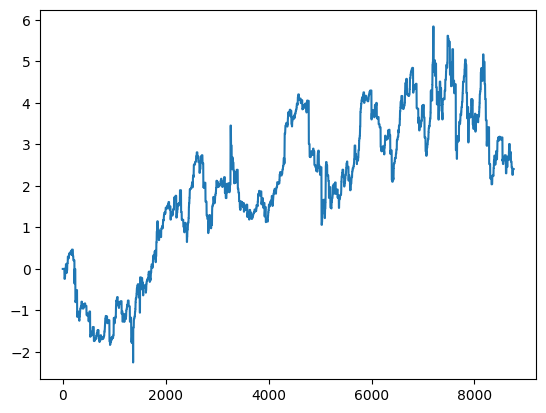

In [108]:
mean_revert_with_pnl(data[['ratio']], 'ratio', 10, 0.5, 1.5, 1)['pnl'].plot()